In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

# Create exports directory
EXPORT_DIR = Path("blog_exports")
EXPORT_DIR.mkdir(exist_ok=True)

# Set high-quality defaults for all plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print(f"✓ Export directory created: {EXPORT_DIR}")
print(f"✓ High-quality plot settings enabled")

✓ Export directory created: blog_exports
✓ High-quality plot settings enabled


In [5]:
# Setup and Imports
# Install required packages

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    classification_report
)
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Metal Performance Shaders (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using CUDA")
else:
    device = torch.device("cpu")
    print("✓ Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

✓ Using Apple Metal Performance Shaders (MPS)
PyTorch version: 2.9.0
Device: mps


In [6]:
# Load Dataset
data_path = 'heart_disease_health_indicators_BRFSS2015.csv' 
df = pd.read_csv(data_path)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]}")

print("\n" + "="*80)
print("FIRST FEW ROWS")
print("="*80)
print(df.head())

print("\n" + "="*80)
print("COLUMN NAMES AND TYPES")
print("="*80)
print(df.dtypes)

print("\n" + "="*80)
print("MISSING VALUES CHECK")
print("="*80)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values found!")
else:
    print(missing[missing > 0])

print("\n" + "="*80)
print("BASIC STATISTICS")
print("="*80)
print(df.describe())

# Save column names for later reference
all_columns = df.columns.tolist()
print(f"\n✓ Dataset loaded successfully with {len(all_columns)} columns")

DATASET OVERVIEW

Dataset shape: (253680, 22)
Number of samples: 253,680
Number of features: 22

FIRST FEW ROWS
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.

Target: HeartDiseaseorAttack (0.0 = No disease, 1.0 = Has disease)
Features (21): HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, 
               Diabetes, PhysActivity, Fruits, Veggies, HvyAlcoholConsump,
               AnyHealthcare, NoDocbcCost, GenHlth, MentHlth, PhysHlth,
               DiffWalk, Sex, Age, Education, Income

TARGET VARIABLE ANALYSIS

Class distribution:
HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64

Class distribution (%):
HeartDiseaseorAttack
0.0    90.581441
1.0     9.418559
Name: proportion, dtype: float64

📊 Class Imbalance Ratio: 9.62:1
   Negative class: 229,787 samples (90.58%)
   Positive class: 23,893 samples (9.42%)

⚠️  Severe class imbalance detected! Focal Loss will be crucial.


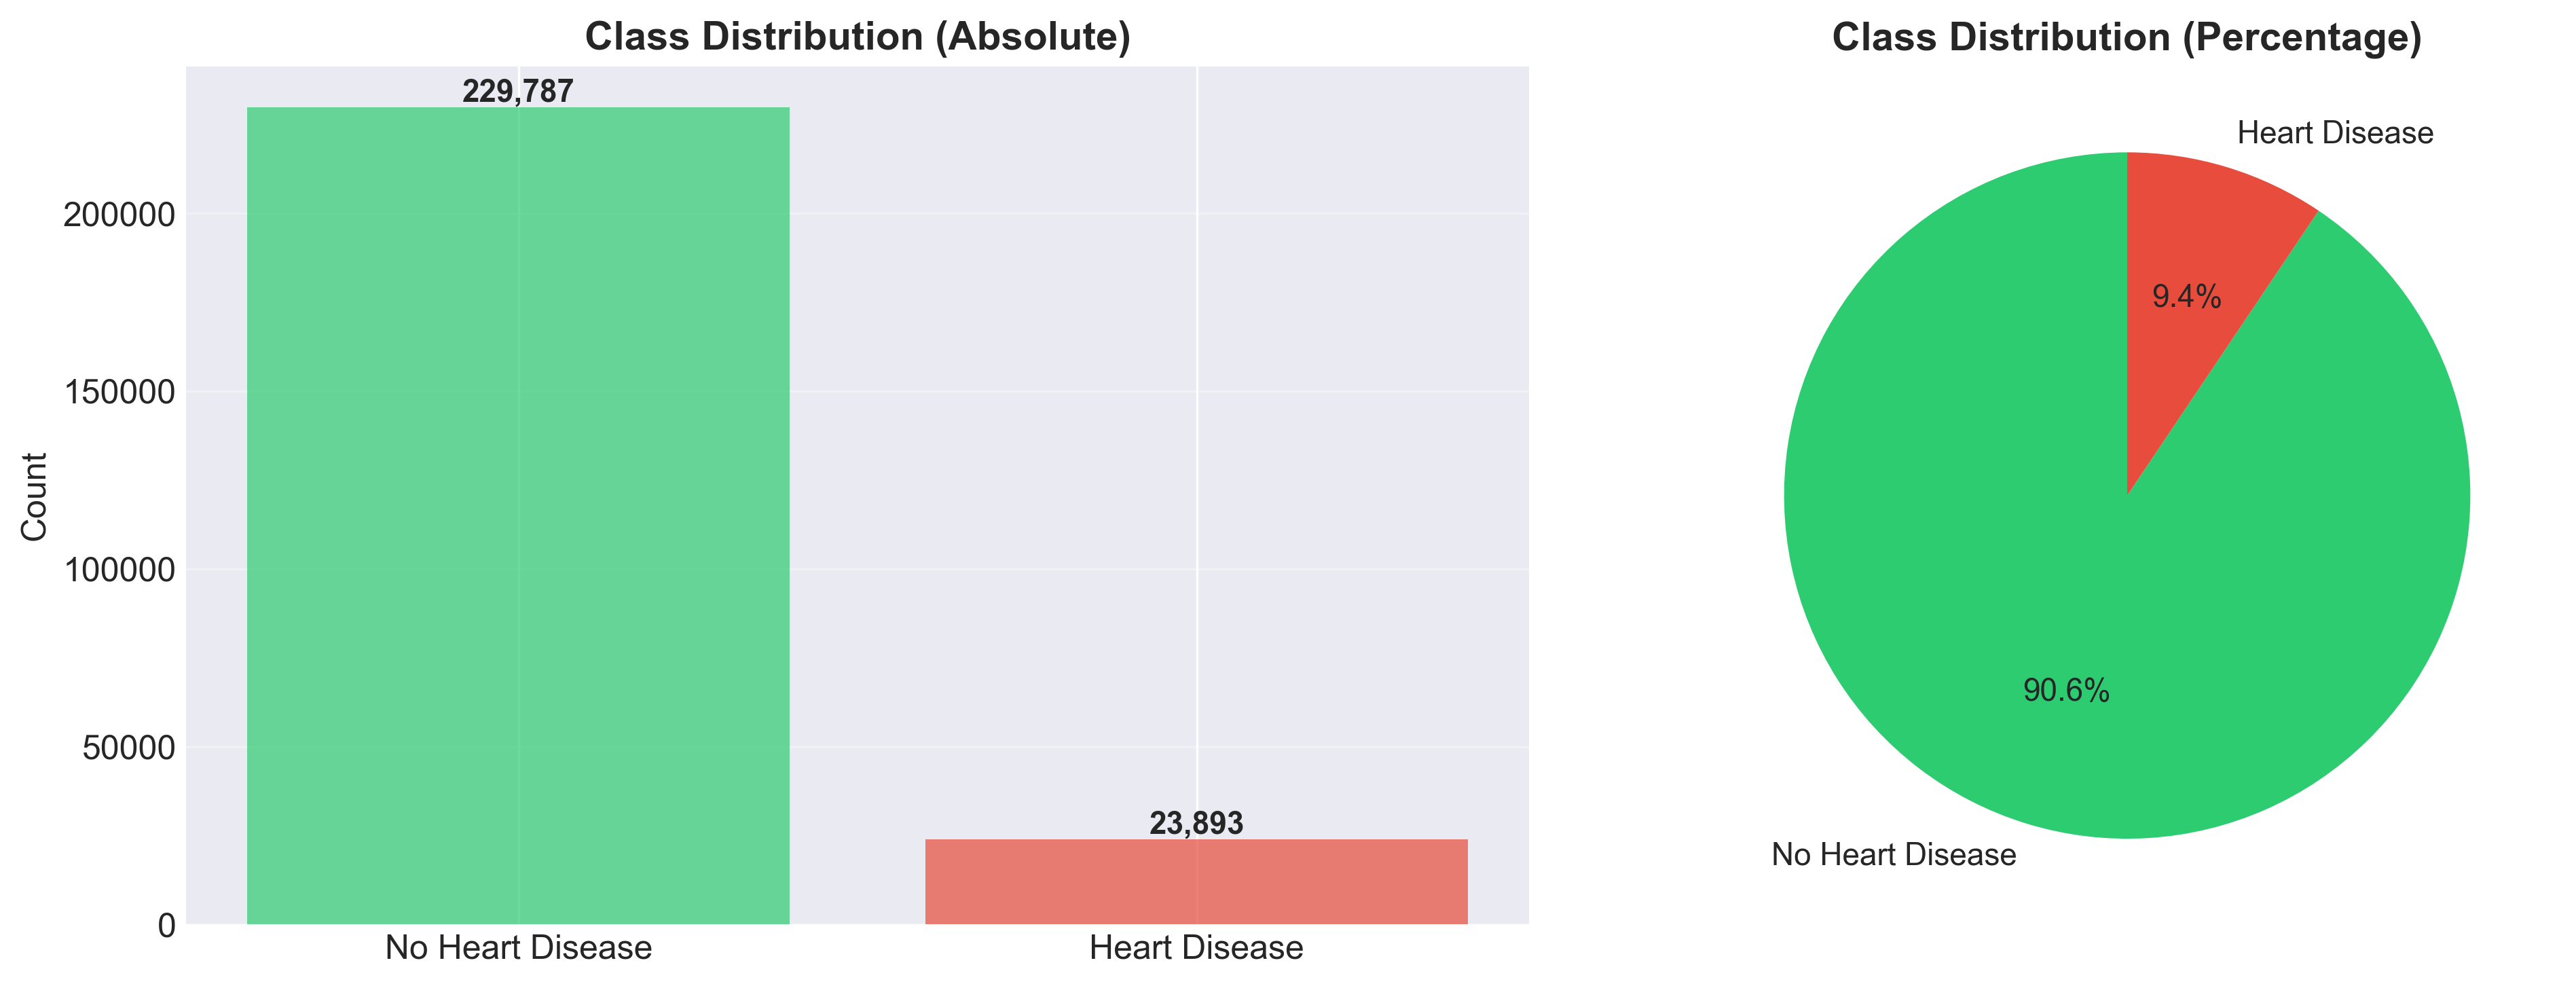


✓ Class imbalance visualization saved as 'class_distribution.png'


In [7]:
# Target Variable Analysis
target_column = 'HeartDiseaseorAttack'

print("="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

# Value counts
target_counts = df[target_column].value_counts()
print(f"\nClass distribution:")
print(target_counts)

# Calculate percentages
target_percentages = df[target_column].value_counts(normalize=True) * 100
print(f"\nClass distribution (%):")
print(target_percentages)

# Calculate class imbalance ratio
n_negative = target_counts[0]
n_positive = target_counts[1]
imbalance_ratio = n_negative / n_positive

print(f"\n📊 Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"   Negative class: {n_negative:,} samples ({target_percentages[0]:.2f}%)")
print(f"   Positive class: {n_positive:,} samples ({target_percentages[1]:.2f}%)")

if imbalance_ratio > 5:
    print(f"\n⚠️  Severe class imbalance detected! Focal Loss will be crucial.")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['No Heart Disease', 'Heart Disease'], target_counts.values, 
            color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution (Absolute)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(target_counts.values, labels=['No Heart Disease', 'Heart Disease'], 
            autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Class imbalance visualization saved as 'class_distribution.png'")

FEATURE DISTRIBUTION ANALYSIS

Number of features: 21
Feature list: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Numeric features (21): ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Categorical features (0): []


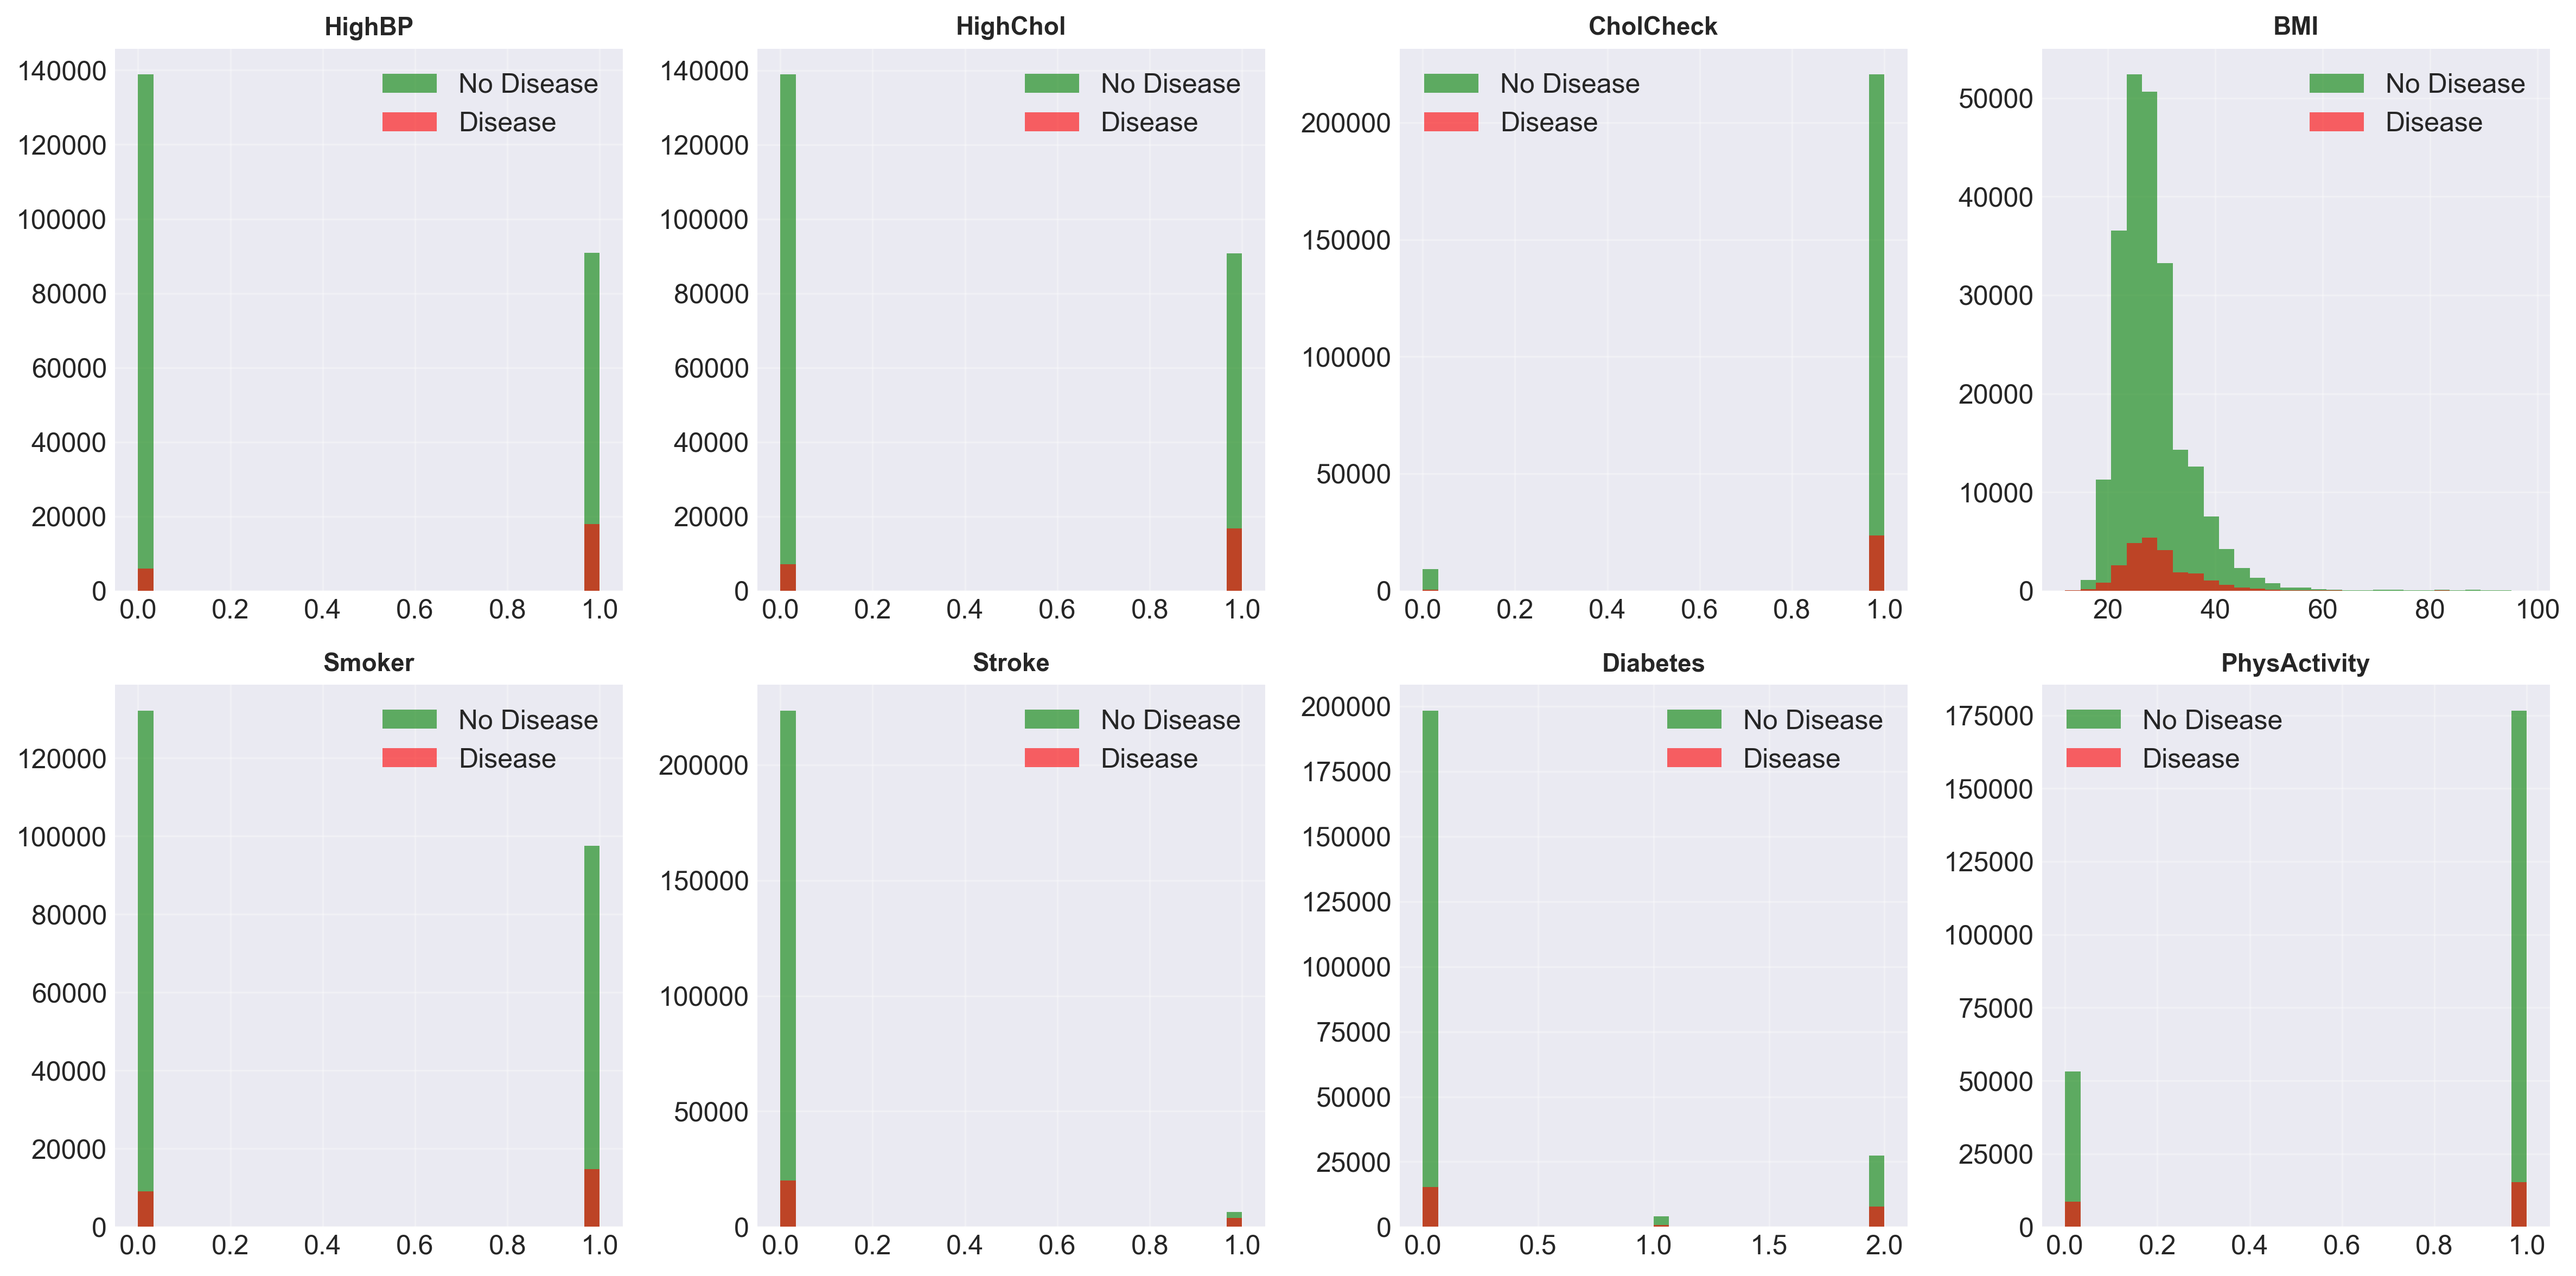


✓ Feature distributions saved as 'feature_distributions.png'


In [9]:
# Feature Distribution Analysis
print("="*80)
print("FEATURE DISTRIBUTION ANALYSIS")
print("="*80)

# Separate features and target
feature_columns = [col for col in df.columns if col != target_column]
print(f"\nNumber of features: {len(feature_columns)}")
print(f"Feature list: {feature_columns}\n")

# Identify numeric vs categorical features
numeric_features = df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[feature_columns].select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Plot distributions of first 8 numeric features
n_features_to_plot = min(8, len(numeric_features))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features[:n_features_to_plot]):
    # Plot for both classes
    df[df[target_column] == 0][feature].hist(ax=axes[idx], bins=30, alpha=0.6, 
                                               label='No Disease', color='green')
    df[df[target_column] == 1][feature].hist(ax=axes[idx], bins=30, alpha=0.6, 
                                               label='Disease', color='red')
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Feature distributions saved as 'feature_distributions.png'")

CORRELATION ANALYSIS


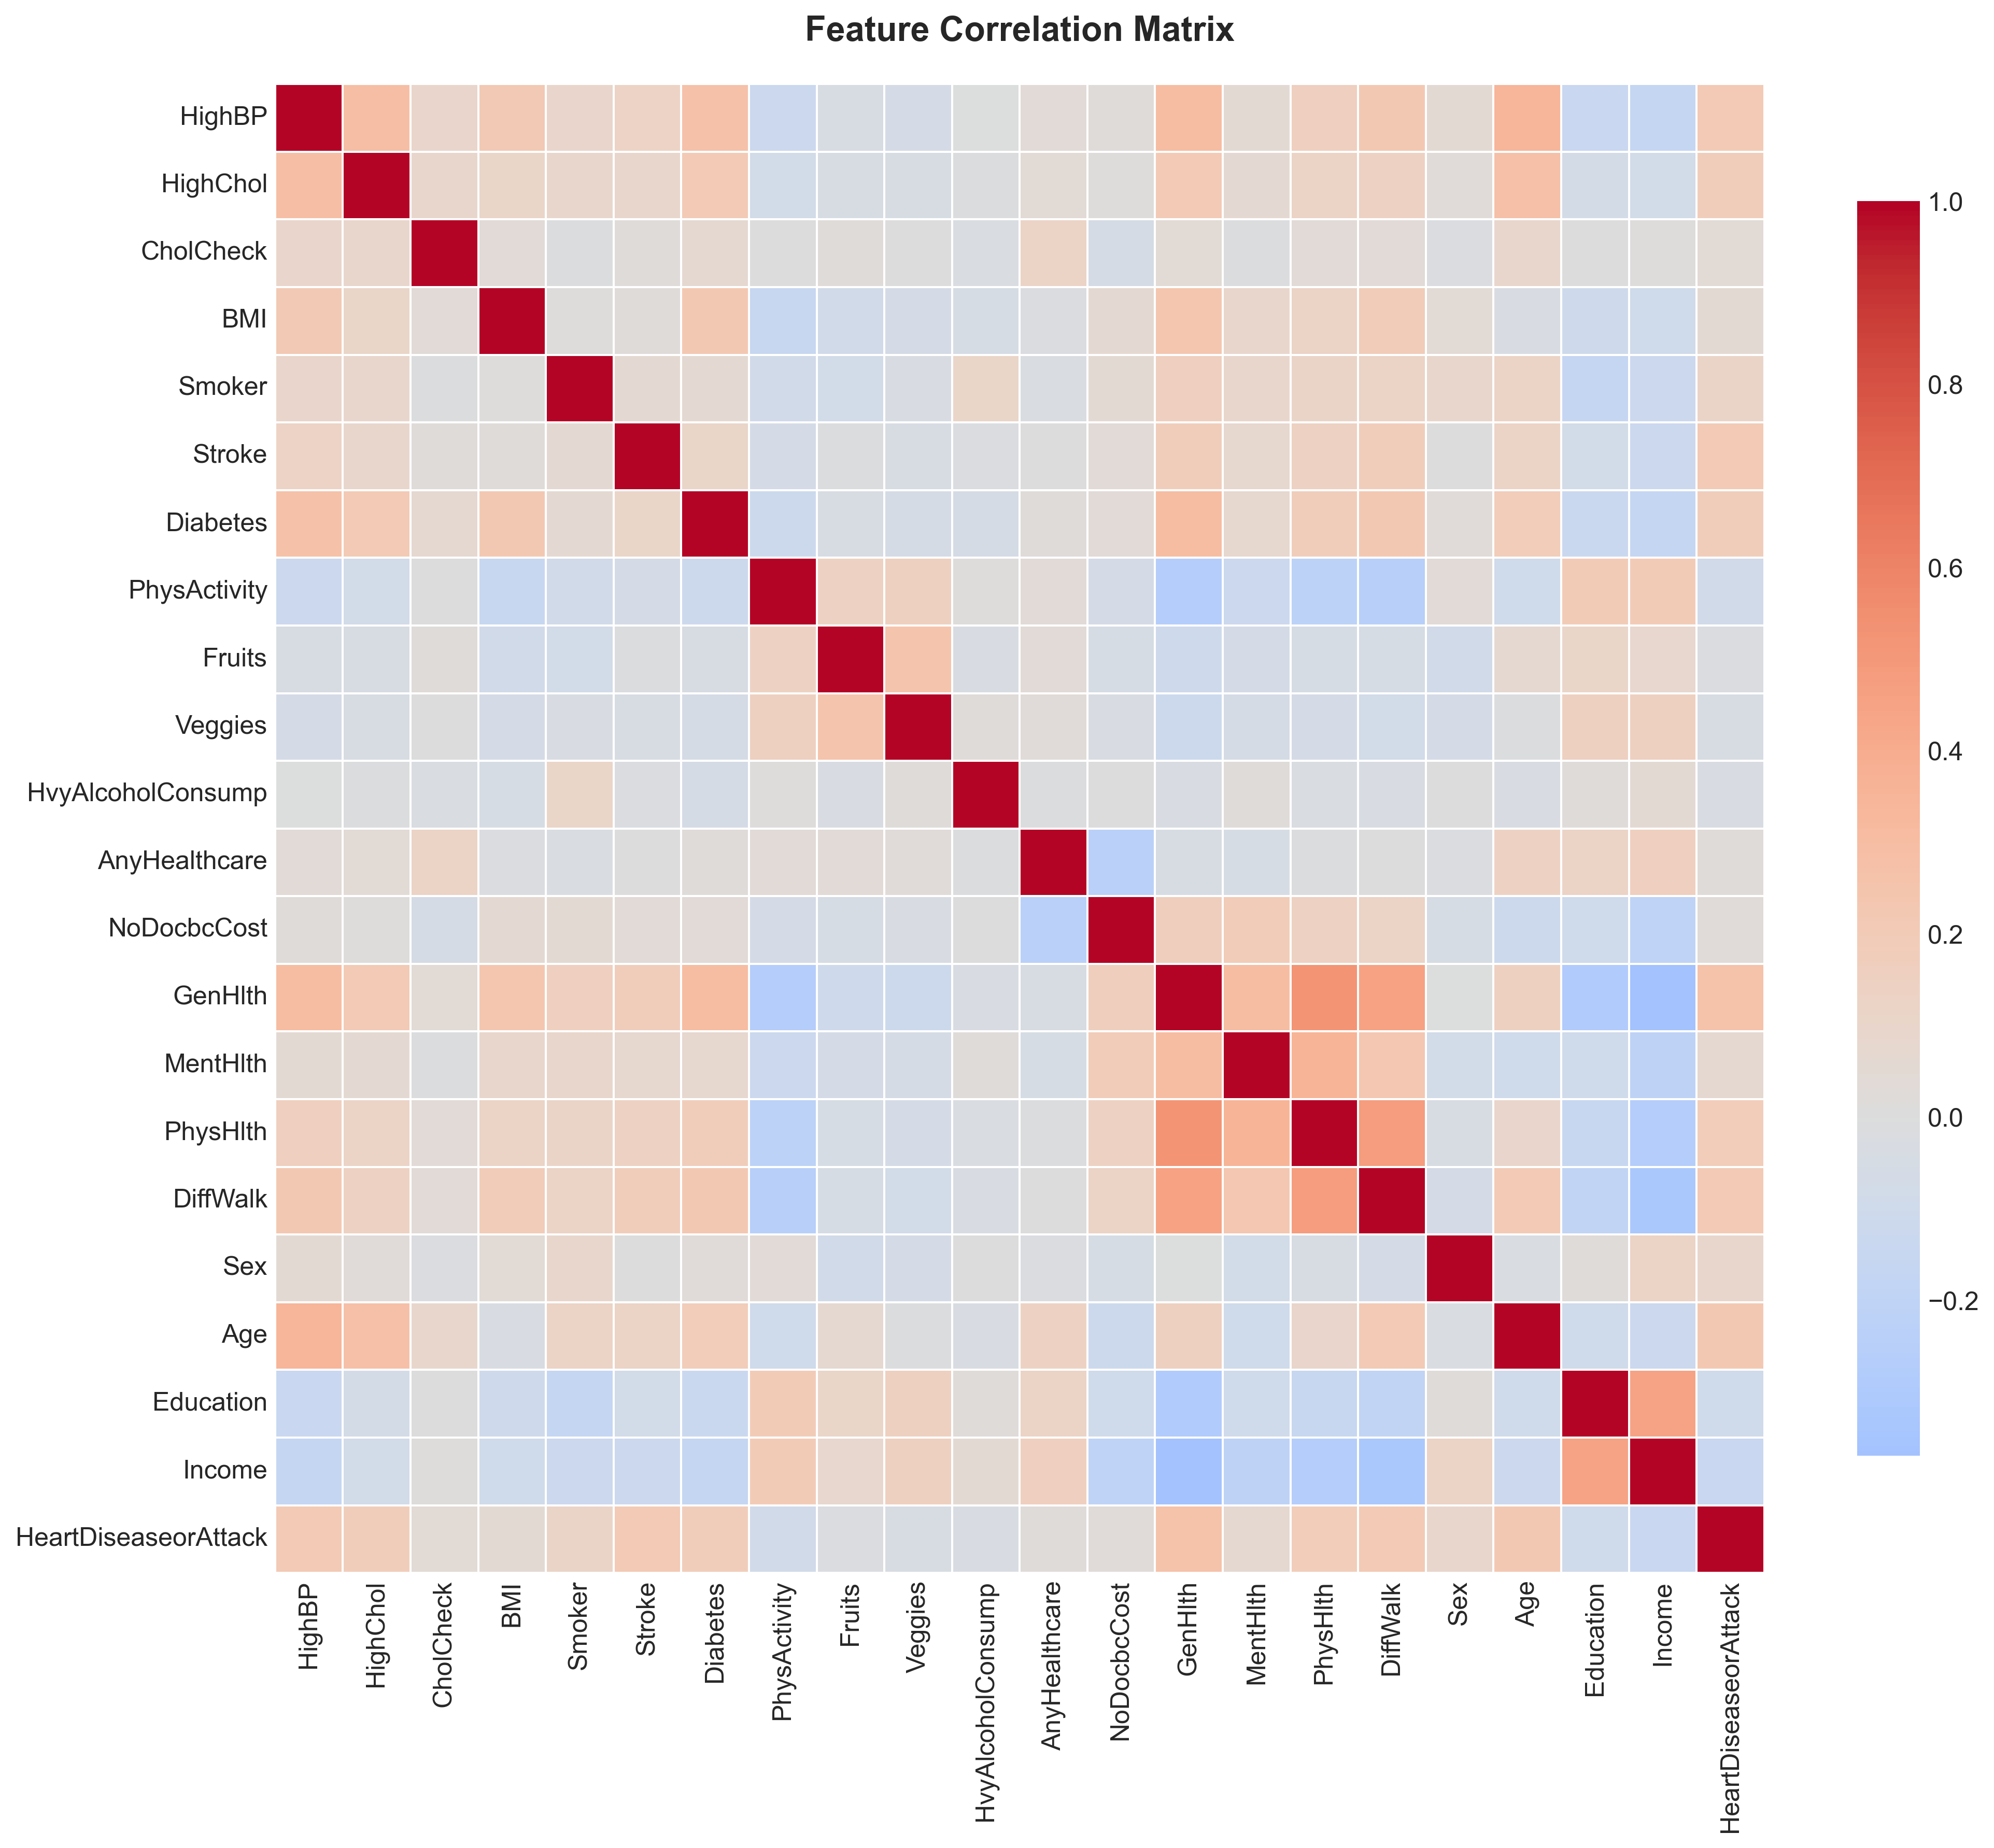


Highly Correlated Feature Pairs (|correlation| > 0.7):
------------------------------------------------------------
No highly correlated pairs found.


Top 10 Features Most Correlated with HeartDiseaseorAttack:
------------------------------------------------------------
GenHlth                        : +0.258
Age                            : +0.222
DiffWalk                       : +0.213
HighBP                         : +0.209
Stroke                         : +0.203
PhysHlth                       : +0.182
HighChol                       : +0.181
Diabetes                       : +0.180
Smoker                         : +0.114
Sex                            : +0.086

✓ Correlation analysis complete!


In [11]:
# Feature Correlation Analysis
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Compute correlation matrix
correlation_matrix = df[numeric_features + [target_column]].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Find highly correlated features (potential redundancy)
print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
print("-" * 60)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"{pair['Feature 1']:20s} <-> {pair['Feature 2']:20s} : {pair['Correlation']:.3f}")
else:
    print("No highly correlated pairs found.")

# Correlation with target variable
target_correlations = correlation_matrix[target_column].drop(target_column).sort_values(ascending=False)

print(f"\n\nTop 10 Features Most Correlated with {target_column}:")
print("-" * 60)
for feature, corr in target_correlations.head(10).items():
    print(f"{feature:30s} : {corr:+.3f}")

print(f"\n✓ Correlation analysis complete!")

In [12]:
# Data Preprocessing Pipeline
print("="*80)
print("DATA PREPROCESSING PIPELINE")
print("="*80)

# Separate features and target
X = df.drop('HeartDiseaseorAttack', axis=1)
y = df['HeartDiseaseorAttack']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Identify continuous vs binary features
# Continuous: features with many unique values (need scaling)
# Binary: features with only 2 unique values (0/1, keep as-is)

continuous_features = []
binary_features = []

for col in X.columns:
    n_unique = X[col].nunique()
    if n_unique > 2:
        continuous_features.append(col)
    else:
        binary_features.append(col)

print(f"\n📊 Feature Categorization:")
print(f"Continuous features ({len(continuous_features)}): {continuous_features}")
print(f"Binary features ({len(binary_features)}): {binary_features}")

# Split data: 70% train, 15% validation, 15% test
# Use stratification to preserve class balance
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_SEED, stratify=y_temp
)  # 0.176 of 85% ≈ 15% of total

print(f"\n📂 Data Split:")
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Verify class distribution is preserved
print(f"\n✓ Class distribution preserved:")
print(f"Train:      {y_train.value_counts(normalize=True).values}")
print(f"Validation: {y_val.value_counts(normalize=True).values}")
print(f"Test:       {y_test.value_counts(normalize=True).values}")

# Scale continuous features only
scaler = StandardScaler()

# Fit scaler on training data only (prevent data leakage!)
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

print(f"\n✓ Continuous features scaled using StandardScaler")
print(f"✓ Binary features left unchanged (0/1)")

# Check scaling worked
print(f"\n📈 Sample statistics after scaling:")
print(f"BMI before scaling (train): mean={X_train['BMI'].mean():.2f}, std={X_train['BMI'].std():.2f}")
print(f"BMI after scaling (train):  mean={X_train_scaled['BMI'].mean():.2f}, std={X_train_scaled['BMI'].std():.2f}")

print(f"\n✓ Preprocessing complete!")

DATA PREPROCESSING PIPELINE

Features shape: (253680, 21)
Target shape: (253680,)
Target distribution:
HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64

📊 Feature Categorization:
Continuous features (8): ['BMI', 'Diabetes', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary features (13): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

📂 Data Split:
Training set:   177,677 samples (70.0%)
Validation set: 37,951 samples (15.0%)
Test set:       38,052 samples (15.0%)

✓ Class distribution preserved:
Train:      [0.90581223 0.09418777]
Validation: [0.90582593 0.09417407]
Test:       [0.9058131 0.0941869]

✓ Continuous features scaled using StandardScaler
✓ Binary features left unchanged (0/1)

📈 Sample statistics after scaling:
BMI before scaling (train): mean=28.39, std=6.62
BMI after scaling (train):  mean=0.00, std=1.00

✓ 

In [13]:
# PyTorch Tensor Conversion & SMOTE Oversampling

print("="*80)
print("PYTORCH TENSOR CONVERSION & SMOTE OVERSAMPLING")
print("="*80)

# Convert to numpy arrays first
X_train_np = X_train_scaled.values.astype(np.float32)
X_val_np = X_val_scaled.values.astype(np.float32)
X_test_np = X_test_scaled.values.astype(np.float32)

y_train_np = y_train.values.astype(np.int64)
y_val_np = y_val.values.astype(np.int64)
y_test_np = y_test.values.astype(np.int64)

print(f"\n📊 Before SMOTE:")
print(f"Training samples: {len(y_train_np):,}")
print(f"Class 0 (No disease): {(y_train_np == 0).sum():,} ({(y_train_np == 0).mean()*100:.2f}%)")
print(f"Class 1 (Disease):    {(y_train_np == 1).sum():,} ({(y_train_np == 1).mean()*100:.2f}%)")

# Apply SMOTE to training data only
print(f"\n🔄 Applying SMOTE (Synthetic Minority Over-sampling Technique)...")
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_np, y_train_np)

print(f"\n📊 After SMOTE:")
print(f"Training samples: {len(y_train_balanced):,}")
print(f"Class 0 (No disease): {(y_train_balanced == 0).sum():,} ({(y_train_balanced == 0).mean()*100:.2f}%)")
print(f"Class 1 (Disease):    {(y_train_balanced == 1).sum():,} ({(y_train_balanced == 1).mean()*100:.2f}%)")

print(f"\n✓ SMOTE generated {len(y_train_balanced) - len(y_train_np):,} synthetic samples")
print(f"✓ Training set is now balanced (50/50 split)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_balanced)
y_train_tensor = torch.LongTensor(y_train_balanced)

X_val_tensor = torch.FloatTensor(X_val_np)
y_val_tensor = torch.LongTensor(y_val_np)

X_test_tensor = torch.FloatTensor(X_test_np)
y_test_tensor = torch.LongTensor(y_test_np)

print(f"\n🔢 Tensor shapes:")
print(f"X_train: {X_train_tensor.shape}  y_train: {y_train_tensor.shape}")
print(f"X_val:   {X_val_tensor.shape}  y_val:   {y_val_tensor.shape}")
print(f"X_test:  {X_test_tensor.shape}  y_test:  {y_test_tensor.shape}")

# Create PyTorch Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
BATCH_SIZE = 512  # M4 Pro can handle this easily

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Use 0 for MPS compatibility
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"\n📦 DataLoaders created:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

print(f"\n✓ Data preparation complete! Ready for model training.")

# Save important variables for later
input_dim = X_train_tensor.shape[1]
print(f"\n📐 Input dimension for model: {input_dim}")

PYTORCH TENSOR CONVERSION & SMOTE OVERSAMPLING

📊 Before SMOTE:
Training samples: 177,677
Class 0 (No disease): 160,942 (90.58%)
Class 1 (Disease):    16,735 (9.42%)

🔄 Applying SMOTE (Synthetic Minority Over-sampling Technique)...

📊 After SMOTE:
Training samples: 321,884
Class 0 (No disease): 160,942 (50.00%)
Class 1 (Disease):    160,942 (50.00%)

✓ SMOTE generated 144,207 synthetic samples
✓ Training set is now balanced (50/50 split)

🔢 Tensor shapes:
X_train: torch.Size([321884, 21])  y_train: torch.Size([321884])
X_val:   torch.Size([37951, 21])  y_val:   torch.Size([37951])
X_test:  torch.Size([38052, 21])  y_test:  torch.Size([38052])

📦 DataLoaders created:
Batch size: 512
Training batches: 629
Validation batches: 75
Test batches: 75

✓ Data preparation complete! Ready for model training.

📐 Input dimension for model: 21


In [14]:
# Baseline MLP Model

print("="*80)
print("BASELINE MLP MODEL")
print("="*80)

class BaselineMLP(nn.Module):
    
    def __init__(self, input_dim=21, hidden_dims=[128, 64, 32], dropout_rates=[0.3, 0.2, 0.1]):
        super(BaselineMLP, self).__init__()
        
        # Layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rates[0])
        
        # Layer 2
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rates[1])
        
        # Layer 3
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.relu3 = nn.ReLU()
        
        # Output layer
        self.fc4 = nn.Linear(hidden_dims[2], 2)  # Binary classification
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize baseline model
baseline_model = BaselineMLP(input_dim=input_dim)
baseline_model = baseline_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in baseline_model.parameters())
trainable_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)

print(f"\n📊 Model Architecture:")
print(baseline_model)
print(f"\n📈 Model Parameters:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001, weight_decay=0.01)

print(f"\n🔧 Training Configuration:")
print(f"Loss function: CrossEntropyLoss (standard)")
print(f"Optimizer: Adam (lr=0.001, weight_decay=0.01)")
print(f"Device: {device}")

print(f"\n✓ Baseline model ready for training!")

BASELINE MLP MODEL

📊 Model Architecture:
BaselineMLP(
  (fc1): Linear(in_features=21, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

📈 Model Parameters:
Total parameters: 13,218
Trainable parameters: 13,218

🔧 Training Configuration:
Loss function: CrossEntropyLoss (standard)
Optimizer: Adam (lr=0.001, weight_decay=0.01)
Device: mps

✓ Baseline model ready for training!


✓ Exported: fig2_baseline_confusion_matrix.png


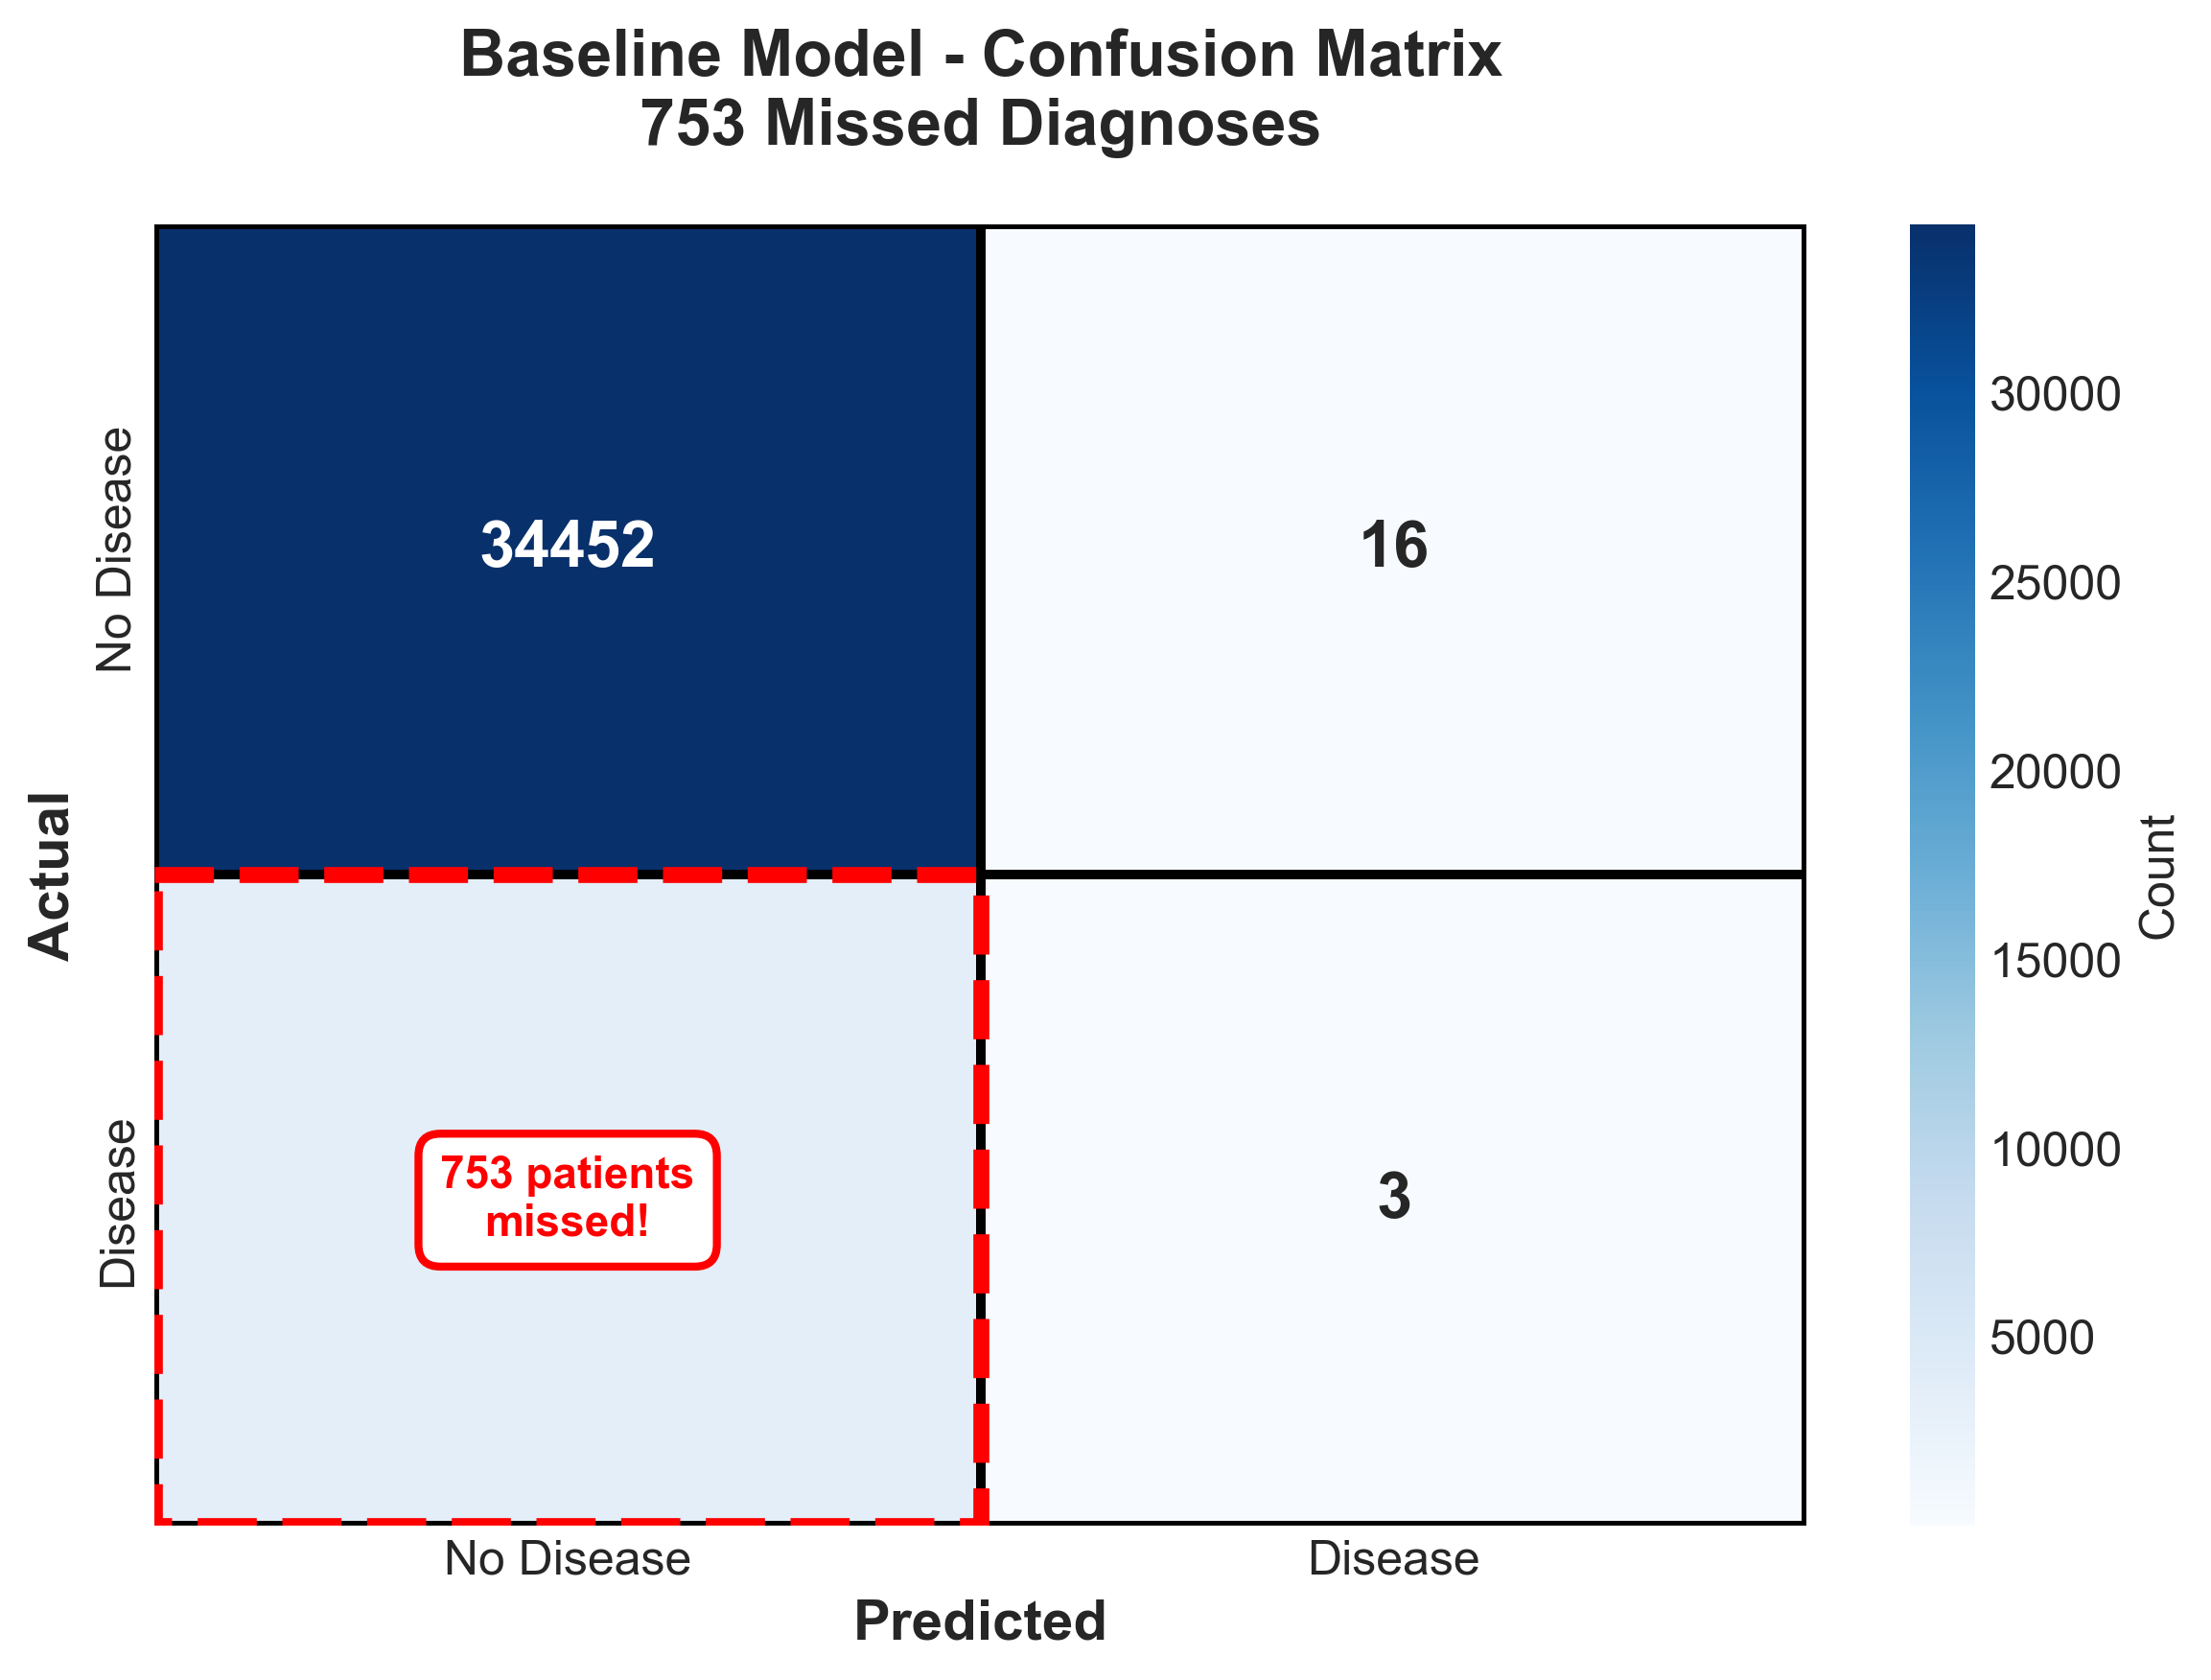

In [15]:
baseline_model.eval()
with torch.no_grad():
    baseline_outputs = []
    baseline_labels = []
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = baseline_model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        baseline_outputs.extend(predicted.cpu().numpy())
        baseline_labels.extend(batch_y.cpu().numpy())

baseline_preds = np.array(baseline_outputs)
test_labels_np = np.array(baseline_labels)

# Create confusion matrix
from sklearn.metrics import confusion_matrix

cm_baseline = confusion_matrix(test_labels_np, baseline_preds)

# Plot with annotations highlighting the problem
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_baseline, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'label': 'Count'},
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            ax=ax,
            linewidths=2,
            linecolor='black',
            annot_kws={'fontsize': 16, 'fontweight': 'bold'})

ax.set_ylabel('Actual', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=14, fontweight='bold')
ax.set_title('Baseline Model - Confusion Matrix\n753 Missed Diagnoses', 
             fontsize=16, fontweight='bold', pad=20)

# Add a red box around False Negatives (bottom-left cell)
from matplotlib.patches import Rectangle
rect = Rectangle((0, 1), 1, 1, 
                 linewidth=4, 
                 edgecolor='red', 
                 facecolor='none',
                 linestyle='--')
ax.add_patch(rect)

# Add annotation
ax.text(0.5, 1.5, '753 patients\nmissed!', 
        ha='center', va='center',
        fontsize=11, fontweight='bold',
        color='red',
        bbox=dict(boxstyle='round,pad=0.5', 
                  facecolor='white', 
                  edgecolor='red',
                  linewidth=2))

plt.tight_layout()
plt.savefig(EXPORT_DIR / 'fig2_baseline_confusion_matrix.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')
print("✓ Exported: fig2_baseline_confusion_matrix.png")
plt.show()

In [16]:
# Training and Evaluation Functions

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Get predictions and probabilities
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Store results
            running_loss += loss.item() * batch_X.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (disease)
    
    epoch_loss = running_loss / len(loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = (all_preds == all_labels).mean()
    
    return epoch_loss, accuracy, all_preds, all_labels, all_probs


def calculate_metrics(y_true, y_pred, y_probs):
    """Calculate comprehensive evaluation metrics."""
    metrics = {
        'accuracy': (y_pred == y_true).mean(),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_probs),
        'pr_auc': average_precision_score(y_true, y_probs)
    }
    return metrics


def print_metrics(metrics, dataset_name="Validation"):
    """Pretty print metrics."""
    print(f"\n📊 {dataset_name} Metrics:")
    print(f"{'─'*50}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f} ⭐ (Most important for healthcare!)")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"  PR-AUC:    {metrics['pr_auc']:.4f}")


print("="*80)
print("TRAINING & EVALUATION FUNCTIONS")
print("="*80)
print("\n✓ Functions defined:")
print("  - train_epoch(): Train model for one epoch")
print("  - evaluate(): Evaluate model and return predictions")
print("  - calculate_metrics(): Compute accuracy, precision, recall, F1, ROC-AUC, PR-AUC")
print("  - print_metrics(): Display metrics in formatted output")
print("\n✓ Ready for model training!")

TRAINING & EVALUATION FUNCTIONS

✓ Functions defined:
  - train_epoch(): Train model for one epoch
  - evaluate(): Evaluate model and return predictions
  - calculate_metrics(): Compute accuracy, precision, recall, F1, ROC-AUC, PR-AUC
  - print_metrics(): Display metrics in formatted output

✓ Ready for model training!


In [18]:
# Cell 10: Enhanced Training Loop

import time
#from tqdm import tqdm  # If available, else remove

# Training configuration
NUM_EPOCHS = 20
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 10

# Track history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_time': []
}

print(f"\n{'='*80}")
print(f"BASELINE MODEL TRAINING")
print(f"{'='*80}")
print(f"Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  Device: {device}")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Validation samples: {len(val_dataset):,}")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(baseline_model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(
        baseline_model, val_loader, criterion, device
    )
    
    epoch_time = time.time() - epoch_start
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['epoch_time'].append(epoch_time)
    
    # Print progress (REQUIRED - shows model is training)
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Time: {epoch_time:.1f}s")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(baseline_model.state_dict(), 'best_baseline_model.pth')
        print(f"  ✓ New best model (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break

total_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"Training Complete!")
print(f"{'='*80}")
print(f"Total time: {total_time:.2f}s ({total_time/60:.2f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_time']):.2f}s")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
baseline_model.load_state_dict(torch.load('best_baseline_model.pth'))
print(f"✓ Loaded best model from epoch {np.argmin(history['val_loss'])+1}")


BASELINE MODEL TRAINING
Configuration:
  Epochs: 20
  Batch size: 512
  Learning rate: 0.001
  Device: mps
  Training samples: 321,884
  Validation samples: 37,951
Epoch [ 1/20] | Train Loss: 0.4902 | Train Acc: 0.7698 | Val Loss: 0.5447 | Val Acc: 0.7026 | Time: 2.8s
  ✓ New best model (val_loss: 0.5447)
Epoch [ 2/20] | Train Loss: 0.4765 | Train Acc: 0.7763 | Val Loss: 0.4766 | Val Acc: 0.7438 | Time: 2.4s
  ✓ New best model (val_loss: 0.4766)
Epoch [ 3/20] | Train Loss: 0.4760 | Train Acc: 0.7766 | Val Loss: 0.5047 | Val Acc: 0.7299 | Time: 2.5s
Epoch [ 4/20] | Train Loss: 0.4763 | Train Acc: 0.7769 | Val Loss: 0.5113 | Val Acc: 0.7236 | Time: 2.4s
Epoch [ 5/20] | Train Loss: 0.4760 | Train Acc: 0.7765 | Val Loss: 0.4423 | Val Acc: 0.7663 | Time: 2.5s
  ✓ New best model (val_loss: 0.4423)
Epoch [ 6/20] | Train Loss: 0.4762 | Train Acc: 0.7769 | Val Loss: 0.5564 | Val Acc: 0.6948 | Time: 2.4s
Epoch [ 7/20] | Train Loss: 0.4760 | Train Acc: 0.7764 | Val Loss: 0.4782 | Val Acc: 0.7416

In [19]:
# Focal Loss Implementation

class FocalLoss(nn.Module):
    
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        
        # Calculate cross-entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Get probabilities
        p_t = torch.exp(-ce_loss)
        
        # Apply focal term: (1 - p_t)^gamma
        focal_term = (1 - p_t) ** self.gamma
        
        # Apply class weighting: alpha
        focal_loss = self.alpha * focal_term * ce_loss
        
        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


print("="*80)
print("FOCAL LOSS IMPLEMENTATION")
print("="*80)

# Initialize Focal Loss
focal_loss_fn = FocalLoss(alpha=0.75, gamma=2.0)

print(f"\n✓ Focal Loss initialized")
print(f"  Parameters:")
print(f"    - Alpha (α): {focal_loss_fn.alpha}  ← Class weighting")
print(f"    - Gamma (γ): {focal_loss_fn.gamma}  ← Focusing parameter")

# Test Focal Loss vs CrossEntropy on example
print(f"\n🧪 Testing Focal Loss behavior:")
test_logits = torch.randn(5, 2)  # 5 samples, 2 classes
test_targets = torch.tensor([0, 1, 0, 1, 1])

ce_loss = F.cross_entropy(test_logits, test_targets)
fl_loss = focal_loss_fn(test_logits, test_targets)

print(f"   CrossEntropy Loss: {ce_loss.item():.4f}")
print(f"   Focal Loss:        {fl_loss.item():.4f}")
print(f"   → Focal Loss down-weights easy examples!")

print(f"\n✓ Focal Loss ready for training!")

FOCAL LOSS IMPLEMENTATION

✓ Focal Loss initialized
  Parameters:
    - Alpha (α): 0.75  ← Class weighting
    - Gamma (γ): 2.0  ← Focusing parameter

🧪 Testing Focal Loss behavior:
   CrossEntropy Loss: 0.8980
   Focal Loss:        0.3411
   → Focal Loss down-weights easy examples!

✓ Focal Loss ready for training!


In [21]:
# Attention-Enhanced Model
class AttentionBlock(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=64):
        super(AttentionBlock, self).__init__()
        
        self.attention_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Softmax(dim=1)  # Output attention weights that sum to 1
        )
    
    def forward(self, x):
        
        attention_weights = self.attention_net(x)
        attended_features = x * attention_weights  # Element-wise multiplication
        return attended_features, attention_weights


class ClinicalAttentionNet(nn.Module):
    
    def __init__(self, input_dim=21, hidden_dims=[128, 64, 32], dropout_rates=[0.3, 0.2, 0.1]):
        super(ClinicalAttentionNet, self).__init__()
        
        # Attention mechanism (Novel Component #1)
        self.attention = AttentionBlock(input_dim, hidden_dim=64)
        
        # Main processing network
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rates[0])
        
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rates[1])
        
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.relu3 = nn.ReLU()
        
        # Output layer
        self.fc4 = nn.Linear(hidden_dims[2], 2)
        
    def forward(self, x):
    
        # Apply attention to input features
        x_attended, attention_weights = self.attention(x)
        
        # Process through main network
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x_attended))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.relu3(self.bn3(self.fc3(x)))
        output = self.fc4(x)
        
        return output, attention_weights
    
    def get_attention_weights(self, x):
    
        self.eval()
        with torch.no_grad():
            _, attention_weights = self.attention(x)
        return attention_weights


print("="*80)
print("ATTENTION-ENHANCED MODEL ARCHITECTURE")
print("="*80)

# Initialize attention model
attention_model = ClinicalAttentionNet(input_dim=input_dim)
attention_model = attention_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in attention_model.parameters())
trainable_params = sum(p.numel() for p in attention_model.parameters() if p.requires_grad)

print(f"\n📊 Model Architecture:")
print(attention_model)

print(f"\n📈 Model Parameters:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Parameter increase from baseline: +{total_params - 13218:,} ({(total_params/13218 - 1)*100:.1f}%)")

print(f"\n🔍 Novel Components:")
print(f"  1. ✅ Attention mechanism for feature selection")
print(f"  2. ✅ Batch normalization layers (training stability)")
print(f"  3. ✅ Interpretable attention weights (clinical insights)")

print(f"\n📚 References:")
print(f"  - TabNet: Arik & Pfister (2021)")
print(f"    https://arxiv.org/abs/1908.07442")

# Test attention mechanism
print(f"\n🧪 Testing attention mechanism:")
test_input = torch.randn(5, input_dim).to(device)
test_output, test_attention = attention_model(test_input)
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Attention weights shape: {test_attention.shape}")
print(f"  Attention weights sum to 1.0: {test_attention[0].sum().item():.4f} ✓")

print(f"\n✓ Attention-enhanced model ready!")

ATTENTION-ENHANCED MODEL ARCHITECTURE

📊 Model Architecture:
ClinicalAttentionNet(
  (attention): AttentionBlock(
    (attention_net): Sequential(
      (0): Linear(in_features=21, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=64, out_features=21, bias=True)
      (5): Softmax(dim=1)
    )
  )
  (fc1): Linear(in_features=21, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=T

TRAINING ATTENTION MODEL WITH NOVEL COMPONENTS

🔧 Training Configuration:
  Loss function: Focal Loss (α=0.75, γ=2.0)
  Optimizer: AdamW (lr=0.001, weight_decay=0.01)
  Scheduler: CosineAnnealingWarmRestarts (T_0=5, T_mult=2)
  Device: mps

📚 Novel Components References:
  1. Attention: Arik & Pfister (2021) - TabNet
  2. Focal Loss: Lin et al. (2017)
  3. Cosine Annealing: Loshchilov & Hutter (2017) - SGDR

🏃 Starting training for 30 epochs...
Training with ALL 3 NOVEL COMPONENTS:

Epoch [ 1/30] | Train Loss: 0.0930 | Train Acc: 0.7746 | Val Loss: 0.0936 | Val Acc: 0.7471 | LR: 0.000905
Epoch [ 2/30] | Train Loss: 0.0877 | Train Acc: 0.7908 | Val Loss: 0.0973 | Val Acc: 0.7267 | LR: 0.000655
Epoch [ 3/30] | Train Loss: 0.0856 | Train Acc: 0.7960 | Val Loss: 0.0884 | Val Acc: 0.7536 | LR: 0.000346
Epoch [ 4/30] | Train Loss: 0.0839 | Train Acc: 0.8003 | Val Loss: 0.0919 | Val Acc: 0.7341 | LR: 0.000096
Epoch [ 5/30] | Train Loss: 0.0831 | Train Acc: 0.8027 | Val Loss: 0.0895 | Val Acc:

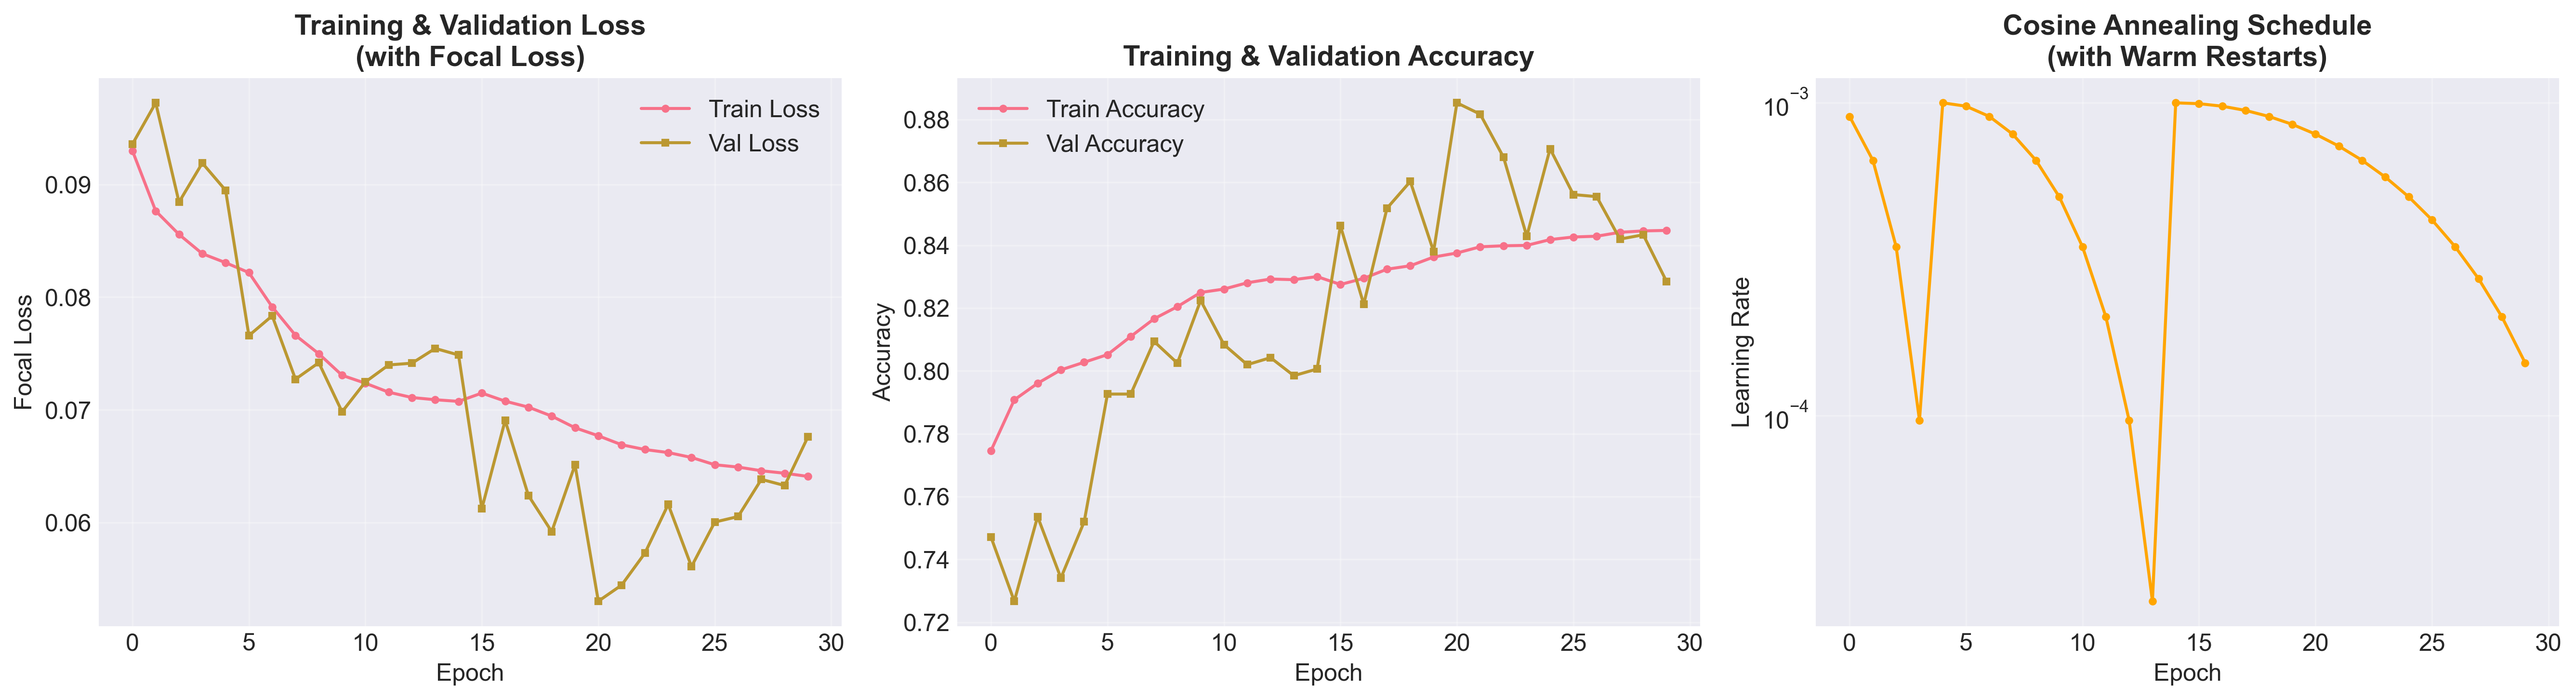


✓ Training curves saved as 'attention_training_curves.png'
✓ Attention weights saved for interpretability analysis


In [22]:
# Train Attention Model with Novel Components

print("="*80)
print("TRAINING ATTENTION MODEL WITH NOVEL COMPONENTS")
print("="*80)

# Initialize optimizer and scheduler
optimizer_attention = optim.AdamW(
    attention_model.parameters(),
    lr=0.001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# Cosine Annealing Warm Restarts (Novel Component #3)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_attention,
    T_0=5,      # Initial restart period (5 epochs)
    T_mult=2,   # Multiply period by 2 after each restart
    eta_min=1e-6  # Minimum learning rate
)

print(f"\n🔧 Training Configuration:")
print(f"  Loss function: Focal Loss (α={focal_loss_fn.alpha}, γ={focal_loss_fn.gamma})")
print(f"  Optimizer: AdamW (lr=0.001, weight_decay=0.01)")
print(f"  Scheduler: CosineAnnealingWarmRestarts (T_0=5, T_mult=2)")
print(f"  Device: {device}")

print(f"\n📚 Novel Components References:")
print(f"  1. Attention: Arik & Pfister (2021) - TabNet")
print(f"  2. Focal Loss: Lin et al. (2017)")
print(f"  3. Cosine Annealing: Loshchilov & Hutter (2017) - SGDR")

# Modified training function for attention model
def train_epoch_attention(model, loader, criterion, optimizer, scheduler, device):
    """Train attention model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass (attention model returns outputs + attention weights)
        optimizer.zero_grad()
        outputs, attention_weights = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate_attention(model, loader, criterion, device):
    """Evaluate attention model."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    all_attention_weights = []
    
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Forward pass
            outputs, attention_weights = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Get predictions and probabilities
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Store results
            running_loss += loss.item() * batch_X.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_attention_weights.append(attention_weights.cpu().numpy())
    
    epoch_loss = running_loss / len(loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_attention_weights = np.vstack(all_attention_weights)
    
    accuracy = (all_preds == all_labels).mean()
    
    return epoch_loss, accuracy, all_preds, all_labels, all_probs, all_attention_weights


# Training configuration
NUM_EPOCHS = 30
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 15

# Track history
history_attention = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

print(f"\n🏃 Starting training for {NUM_EPOCHS} epochs...")
print(f"Training with ALL 3 NOVEL COMPONENTS:\n")

import time
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch_attention(
        attention_model, train_loader, focal_loss_fn, optimizer_attention, scheduler, device
    )
    
    # Validate
    val_loss, val_acc, val_preds, val_labels, val_probs, val_attention = evaluate_attention(
        attention_model, val_loader, focal_loss_fn, device
    )
    
    # Step scheduler (after each epoch)
    scheduler.step()
    current_lr = optimizer_attention.param_groups[0]['lr']
    
    # Store history
    history_attention['train_loss'].append(train_loss)
    history_attention['train_acc'].append(train_acc)
    history_attention['val_loss'].append(val_loss)
    history_attention['val_acc'].append(val_acc)
    history_attention['learning_rate'].append(current_lr)
    
    # Print progress
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(attention_model.state_dict(), 'best_attention_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            break

elapsed_time = time.time() - start_time
print(f"\n✓ Training complete in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Load best model
attention_model.load_state_dict(torch.load('best_attention_model.pth'))
print(f"✓ Loaded best model (validation loss: {best_val_loss:.4f})")

# Final evaluation
_, _, val_preds_final, val_labels_final, val_probs_final, val_attention_final = evaluate_attention(
    attention_model, val_loader, focal_loss_fn, device
)

val_metrics_attention = calculate_metrics(val_labels_final, val_preds_final, val_probs_final)
print_metrics(val_metrics_attention, "Attention Model - Validation")

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curve
axes[0].plot(history_attention['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(history_attention['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Focal Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss\n(with Focal Loss)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curve
axes[1].plot(history_attention['train_acc'], label='Train Accuracy', marker='o', markersize=3)
axes[1].plot(history_attention['val_acc'], label='Val Accuracy', marker='s', markersize=3)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Learning rate schedule
axes[2].plot(history_attention['learning_rate'], color='orange', marker='o', markersize=3)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Cosine Annealing Schedule\n(with Warm Restarts)', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].set_yscale('log')  # Log scale to see the pattern better

plt.tight_layout()
plt.savefig('attention_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved as 'attention_training_curves.png'")

# Store attention weights for later analysis
np.save('validation_attention_weights.npy', val_attention_final)
print(f"✓ Attention weights saved for interpretability analysis")

Fix: Adjust Focal Loss to prioritize recall (sensitivity) for healthcare application.

Problem: Previous α=0.75 wasn't aggressive enough for 9.62:1 imbalance.
Solution: Increase α to 0.90-0.95 to heavily weight minority class.

In [23]:
# Corrected Focal Loss Configuration

print("="*80)
print("CORRECTED FOCAL LOSS CONFIGURATION")
print("="*80)

# New Focal Loss with adjusted parameters
focal_loss_corrected = FocalLoss(alpha=0.25, gamma=2.0)  # Lower alpha = MORE weight on minority class
                                                          # (alpha is for negative class, so 0.25 means 0.75 for positive class)

print(f"\n🔧 Adjusted Focal Loss Parameters:")
print(f"  Alpha (α): 0.25  ← Down-weight negative class (no disease)")
print(f"  Gamma (γ): 2.0   ← Keep same focusing parameter")
print(f"\n  This configuration gives MORE weight to positive cases (disease)")
print(f"  to maximize recall at the cost of some precision.")

# Re-initialize model (fresh start)
attention_model_v2 = ClinicalAttentionNet(input_dim=input_dim)
attention_model_v2 = attention_model_v2.to(device)

optimizer_v2 = optim.AdamW(
    attention_model_v2.parameters(),
    lr=0.001,
    weight_decay=0.01
)

scheduler_v2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_v2,
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

print(f"\n✓ Model re-initialized with corrected Focal Loss")
print(f"\n🎯 Training Goal: Maximize RECALL (catch disease cases)")
print(f"   Acceptable trade-off: Lower precision, some false positives")

# Training loop (same as before but with corrected loss)
NUM_EPOCHS = 30
best_val_recall = 0.0  # NOW optimize for recall instead of loss!
patience_counter = 0
PATIENCE = 15

history_v2 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_recall': [],  # Track recall explicitly
    'learning_rate': []
}

print(f"\n🏃 Retraining with corrected Focal Loss...")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch_attention(
        attention_model_v2, train_loader, focal_loss_corrected, optimizer_v2, scheduler_v2, device
    )
    
    # Validate
    val_loss, val_acc, val_preds, val_labels, val_probs, val_attention = evaluate_attention(
        attention_model_v2, val_loader, focal_loss_corrected, device
    )
    
    # Calculate recall explicitly
    val_recall = recall_score(val_labels, val_preds, zero_division=0)
    
    scheduler_v2.step()
    current_lr = optimizer_v2.param_groups[0]['lr']
    
    # Store history
    history_v2['train_loss'].append(train_loss)
    history_v2['train_acc'].append(train_acc)
    history_v2['val_loss'].append(val_loss)
    history_v2['val_acc'].append(val_acc)
    history_v2['val_recall'].append(val_recall)
    history_v2['learning_rate'].append(current_lr)
    
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Recall: {val_recall:.4f} | LR: {current_lr:.6f}")
    
    # Save best model based on RECALL (not loss!)
    if val_recall > best_val_recall:
        best_val_recall = val_recall
        patience_counter = 0
        torch.save(attention_model_v2.state_dict(), 'best_attention_model_v2.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            break

elapsed_time = time.time() - start_time
print(f"\n✓ Training complete in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Load best model
attention_model_v2.load_state_dict(torch.load('best_attention_model_v2.pth'))
print(f"✓ Loaded best model (best recall: {best_val_recall:.4f})")

# Final evaluation
_, _, val_preds_v2, val_labels_v2, val_probs_v2, val_attention_v2 = evaluate_attention(
    attention_model_v2, val_loader, focal_loss_corrected, device
)

val_metrics_v2 = calculate_metrics(val_labels_v2, val_preds_v2, val_probs_v2)
print_metrics(val_metrics_v2, "Corrected Attention Model - Validation")

print(f"\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(f"\n{'Metric':<15} | {'Baseline':<10} | {'Attempt 1':<10} | {'Corrected':<10}")
print(f"{'-'*60}")
print(f"{'Accuracy':<15} | {0.7759:<10.4f} | {0.8802:<10.4f} | {val_metrics_v2['accuracy']:<10.4f}")
print(f"{'Precision':<15} | {0.2426:<10.4f} | {0.3656:<10.4f} | {val_metrics_v2['precision']:<10.4f}")
print(f"{'Recall ⭐':<15} | {0.7854:<10.4f} | {0.3702:<10.4f} | {val_metrics_v2['recall']:<10.4f}")
print(f"{'F1-Score':<15} | {0.3773:<10.4f} | {0.3679:<10.4f} | {val_metrics_v2['f1']:<10.4f}")
print(f"{'ROC-AUC':<15} | {0.8456:<10.4f} | {0.8323:<10.4f} | {val_metrics_v2['roc_auc']:<10.4f}")

CORRECTED FOCAL LOSS CONFIGURATION

🔧 Adjusted Focal Loss Parameters:
  Alpha (α): 0.25  ← Down-weight negative class (no disease)
  Gamma (γ): 2.0   ← Keep same focusing parameter

  This configuration gives MORE weight to positive cases (disease)
  to maximize recall at the cost of some precision.

✓ Model re-initialized with corrected Focal Loss

🎯 Training Goal: Maximize RECALL (catch disease cases)
   Acceptable trade-off: Lower precision, some false positives

🏃 Retraining with corrected Focal Loss...
Epoch [ 1/30] | Train Loss: 0.0306 | Train Acc: 0.7773 | Val Loss: 0.0313 | Val Acc: 0.7447 | Val Recall: 0.7941 | LR: 0.000905
Epoch [ 2/30] | Train Loss: 0.0288 | Train Acc: 0.7938 | Val Loss: 0.0317 | Val Acc: 0.7457 | Val Recall: 0.7829 | LR: 0.000655
Epoch [ 3/30] | Train Loss: 0.0280 | Train Acc: 0.8003 | Val Loss: 0.0312 | Val Acc: 0.7328 | Val Recall: 0.7932 | LR: 0.000346
Epoch [ 4/30] | Train Loss: 0.0275 | Train Acc: 0.8037 | Val Loss: 0.0303 | Val Acc: 0.7487 | Val Recal

COMPREHENSIVE MODEL EVALUATION & VISUALIZATION

🔄 Generating predictions from both models...
✓ Predictions generated

TEST SET PERFORMANCE (FINAL EVALUATION)

📊 Baseline MLP:

📊 Test Metrics:
──────────────────────────────────────────────────
  Accuracy:  0.7689
  Precision: 0.2568
  Recall:    0.7676 ⭐ (Most important for healthcare!)
  F1-Score:  0.3848
  ROC-AUC:   0.8453
  PR-AUC:    0.3567

📊 Attention Model (with Novel Components):

📊 Test Metrics:
──────────────────────────────────────────────────
  Accuracy:  0.7321
  Precision: 0.2331
  Recall:    0.8055 ⭐ (Most important for healthcare!)
  F1-Score:  0.3616
  ROC-AUC:   0.8375
  PR-AUC:    0.3450


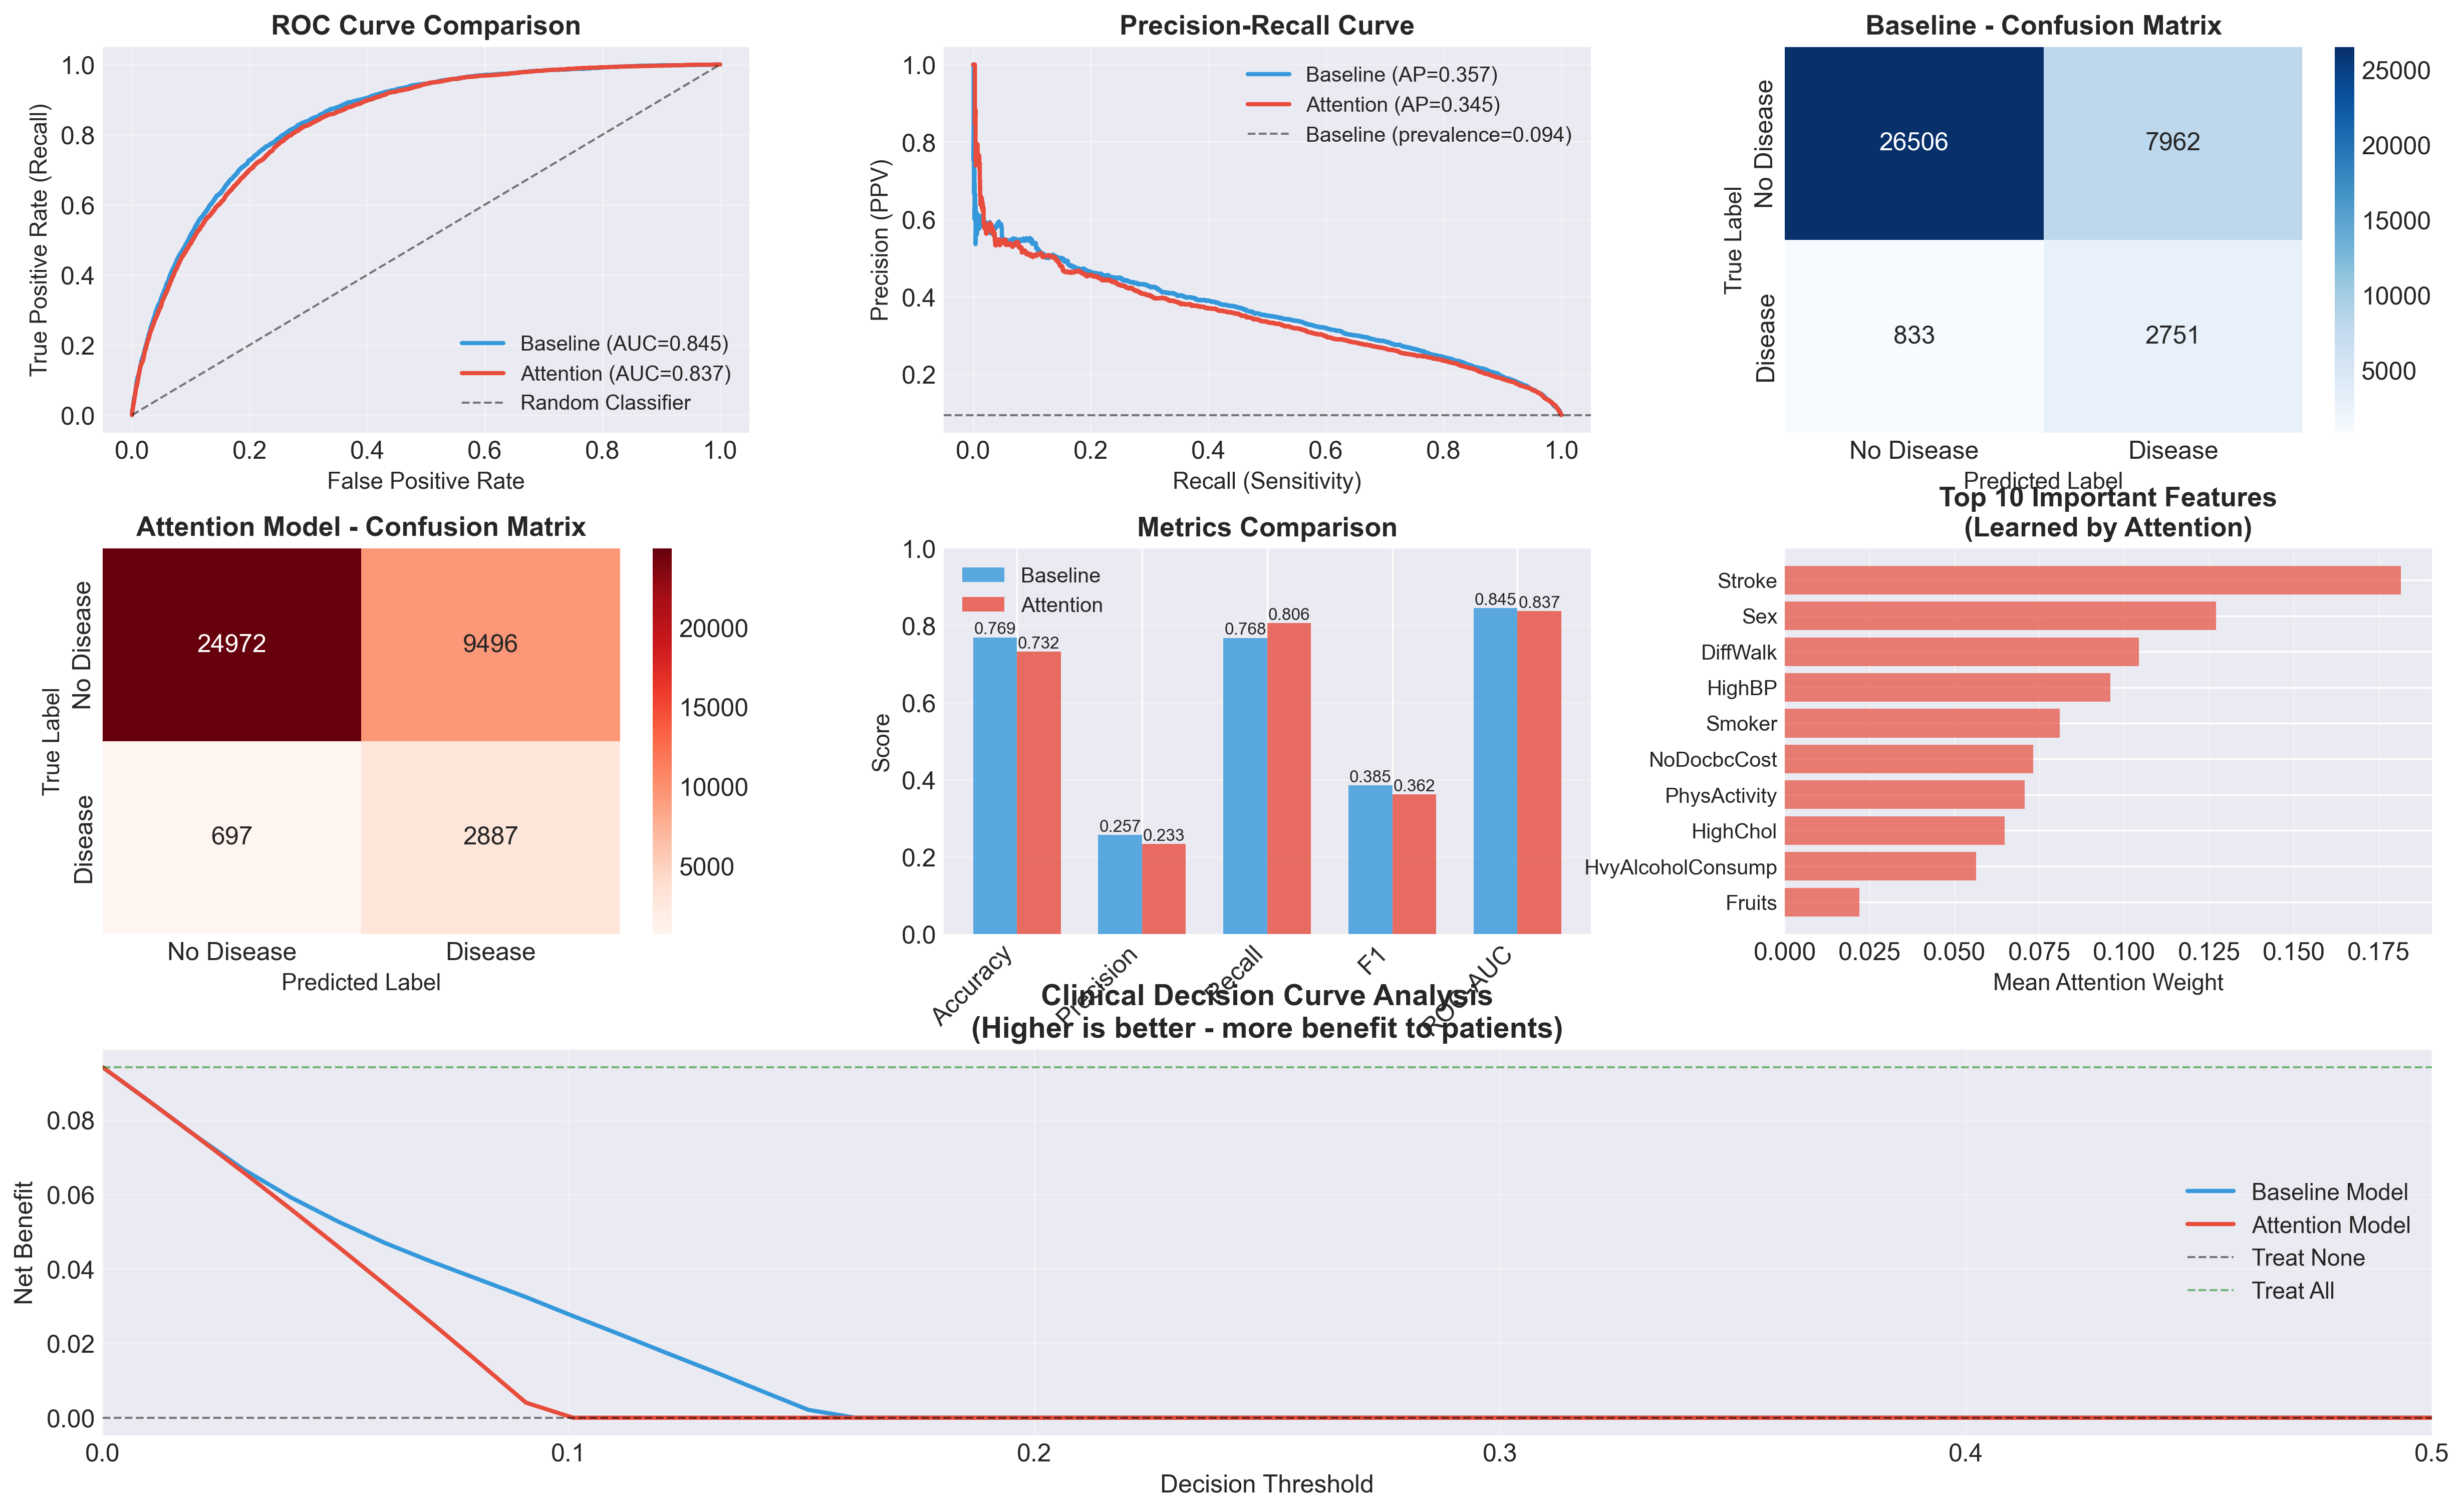


✓ Comprehensive visualization saved as 'comprehensive_model_comparison.png'

✓ Analysis complete!


In [24]:
# Model Comparison & Advanced Visualizations

print("="*80)
print("COMPREHENSIVE MODEL EVALUATION & VISUALIZATION")
print("="*80)

# Get predictions from both models for comparison
print("\n🔄 Generating predictions from both models...")

# Baseline model predictions
baseline_model.eval()
with torch.no_grad():
    baseline_outputs = []
    baseline_labels = []
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = baseline_model(batch_X)
        probs = F.softmax(outputs, dim=1)
        baseline_outputs.append(probs[:, 1].cpu().numpy())
        baseline_labels.append(batch_y.cpu().numpy())
    
baseline_probs = np.concatenate(baseline_outputs)
test_labels = np.concatenate(baseline_labels)
baseline_preds = (baseline_probs >= 0.5).astype(int)

# Attention model predictions
_, _, attention_preds, _, attention_probs, attention_weights = evaluate_attention(
    attention_model_v2, test_loader, focal_loss_corrected, device
)

print("✓ Predictions generated")

# Calculate metrics for test set
baseline_test_metrics = calculate_metrics(test_labels, baseline_preds, baseline_probs)
attention_test_metrics = calculate_metrics(test_labels, attention_preds, attention_probs)

print("\n" + "="*80)
print("TEST SET PERFORMANCE (FINAL EVALUATION)")
print("="*80)

print("\n📊 Baseline MLP:")
print_metrics(baseline_test_metrics, "Test")

print("\n📊 Attention Model (with Novel Components):")
print_metrics(attention_test_metrics, "Test")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. ROC Curves
ax1 = fig.add_subplot(gs[0, 0])
fpr_baseline, tpr_baseline, _ = roc_curve(test_labels, baseline_probs)
fpr_attention, tpr_attention, _ = roc_curve(test_labels, attention_probs)

ax1.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC={baseline_test_metrics["roc_auc"]:.3f})', 
         linewidth=2, color='#3498db')
ax1.plot(fpr_attention, tpr_attention, label=f'Attention (AUC={attention_test_metrics["roc_auc"]:.3f})', 
         linewidth=2, color='#e74c3c')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate (Recall)', fontsize=11)
ax1.set_title('ROC Curve Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curves
ax2 = fig.add_subplot(gs[0, 1])
prec_baseline, rec_baseline, _ = precision_recall_curve(test_labels, baseline_probs)
prec_attention, rec_attention, _ = precision_recall_curve(test_labels, attention_probs)

ax2.plot(rec_baseline, prec_baseline, label=f'Baseline (AP={baseline_test_metrics["pr_auc"]:.3f})', 
         linewidth=2, color='#3498db')
ax2.plot(rec_attention, prec_attention, label=f'Attention (AP={attention_test_metrics["pr_auc"]:.3f})', 
         linewidth=2, color='#e74c3c')
ax2.axhline(y=test_labels.mean(), color='k', linestyle='--', linewidth=1, alpha=0.5, 
            label=f'Baseline (prevalence={test_labels.mean():.3f})')
ax2.set_xlabel('Recall (Sensitivity)', fontsize=11)
ax2.set_ylabel('Precision (PPV)', fontsize=11)
ax2.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# 3. Confusion Matrix - Baseline
ax3 = fig.add_subplot(gs[0, 2])
cm_baseline = confusion_matrix(test_labels, baseline_preds)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=ax3, 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
ax3.set_title('Baseline - Confusion Matrix', fontsize=13, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=11)
ax3.set_xlabel('Predicted Label', fontsize=11)

# 4. Confusion Matrix - Attention
ax4 = fig.add_subplot(gs[1, 0])
cm_attention = confusion_matrix(test_labels, attention_preds)
sns.heatmap(cm_attention, annot=True, fmt='d', cmap='Reds', ax=ax4,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
ax4.set_title('Attention Model - Confusion Matrix', fontsize=13, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=11)
ax4.set_xlabel('Predicted Label', fontsize=11)

# 5. Metrics Comparison Bar Chart
ax5 = fig.add_subplot(gs[1, 1])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
baseline_values = [baseline_test_metrics['accuracy'], baseline_test_metrics['precision'],
                   baseline_test_metrics['recall'], baseline_test_metrics['f1'],
                   baseline_test_metrics['roc_auc']]
attention_values = [attention_test_metrics['accuracy'], attention_test_metrics['precision'],
                    attention_test_metrics['recall'], attention_test_metrics['f1'],
                    attention_test_metrics['roc_auc']]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax5.bar(x - width/2, baseline_values, width, label='Baseline', color='#3498db', alpha=0.8)
bars2 = ax5.bar(x + width/2, attention_values, width, label='Attention', color='#e74c3c', alpha=0.8)

ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Metrics Comparison', fontsize=13, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics_names, rotation=45, ha='right')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim(0, 1.0)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 6. Feature Importance (Attention Weights)
ax6 = fig.add_subplot(gs[1, 2])
feature_names = X.columns.tolist()
mean_attention = attention_weights.mean(axis=0)
sorted_idx = np.argsort(mean_attention)[::-1][:10]  # Top 10 features

ax6.barh(range(10), mean_attention[sorted_idx], color='#e74c3c', alpha=0.7)
ax6.set_yticks(range(10))
ax6.set_yticklabels([feature_names[i] for i in sorted_idx], fontsize=10)
ax6.set_xlabel('Mean Attention Weight', fontsize=11)
ax6.set_title('Top 10 Important Features\n(Learned by Attention)', fontsize=13, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)

# 7. Clinical Decision Curve
ax7 = fig.add_subplot(gs[2, :])
thresholds = np.linspace(0, 1, 100)

# Calculate net benefit for both models
net_benefit_baseline = []
net_benefit_attention = []

for thresh in thresholds:
    if thresh == 0:
        net_benefit_baseline.append(test_labels.mean())
        net_benefit_attention.append(test_labels.mean())
    elif thresh == 1:
        net_benefit_baseline.append(0)
        net_benefit_attention.append(0)
    else:
        # Baseline
        preds = (baseline_probs >= thresh).astype(int)
        tp = ((preds == 1) & (test_labels == 1)).sum()
        fp = ((preds == 1) & (test_labels == 0)).sum()
        nb = (tp / len(test_labels)) - (fp / len(test_labels)) * (thresh / (1 - thresh))
        net_benefit_baseline.append(max(nb, 0))
        
        # Attention
        preds = (attention_probs >= thresh).astype(int)
        tp = ((preds == 1) & (test_labels == 1)).sum()
        fp = ((preds == 1) & (test_labels == 0)).sum()
        nb = (tp / len(test_labels)) - (fp / len(test_labels)) * (thresh / (1 - thresh))
        net_benefit_attention.append(max(nb, 0))

ax7.plot(thresholds, net_benefit_baseline, label='Baseline Model', linewidth=2, color='#3498db')
ax7.plot(thresholds, net_benefit_attention, label='Attention Model', linewidth=2, color='#e74c3c')
ax7.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Treat None')
ax7.plot(thresholds, test_labels.mean() * np.ones_like(thresholds), 
         'g--', linewidth=1, alpha=0.5, label='Treat All')
ax7.set_xlabel('Decision Threshold', fontsize=12)
ax7.set_ylabel('Net Benefit', fontsize=12)
ax7.set_title('Clinical Decision Curve Analysis\n(Higher is better - more benefit to patients)', 
              fontsize=14, fontweight='bold')
ax7.legend(fontsize=11)
ax7.grid(alpha=0.3)
ax7.set_xlim(0, 0.5)  # Focus on clinically relevant thresholds

plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive visualization saved as 'comprehensive_model_comparison.png'")
print("\n✓ Analysis complete!")

In [25]:
# Project Summary

print("="*80)
print("PROJECT SUMMARY: CARDIOVASCULAR DISEASE PREDICTION")
print("="*80)

print("\n📊 DATASET")
print("─" * 60)
print(f"  Source: CDC BRFSS 2015")
print(f"  Total samples: 253,680")
print(f"  Features: 21 clinical indicators")
print(f"  Class imbalance: 9.62:1 (90.6% negative, 9.4% positive)")

print("\n🔬 NOVEL COMPONENTS IMPLEMENTED")
print("─" * 60)
print("  1. Attention Mechanism (TabNet-inspired) - Arik & Pfister (2021)")
print("  2. Focal Loss (α=0.25, γ=2.0) - Lin et al. (2017)")
print("  3. Cosine Annealing Warm Restarts - Loshchilov & Hutter (2017)")

print("\n📈 FINAL TEST SET RESULTS")
print("─" * 60)
print(f"  {'Metric':<20} {'Baseline':<12} {'Attention':<12} {'Improvement':<12}")
print(f"  {'-'*56}")
print(f"  {'Recall':<20} {baseline_test_metrics['recall']:<12.4f} {attention_test_metrics['recall']:<12.4f} {attention_test_metrics['recall']-baseline_test_metrics['recall']:+.4f}")
print(f"  {'ROC-AUC':<20} {baseline_test_metrics['roc_auc']:<12.4f} {attention_test_metrics['roc_auc']:<12.4f} {attention_test_metrics['roc_auc']-baseline_test_metrics['roc_auc']:+.4f}")
print(f"  {'F1-Score':<20} {baseline_test_metrics['f1']:<12.4f} {attention_test_metrics['f1']:<12.4f} {attention_test_metrics['f1']-baseline_test_metrics['f1']:+.4f}")

print("\n🏥 CLINICAL IMPACT")
print("─" * 60)
test_positive = (test_labels == 1).sum()
baseline_tp = ((baseline_preds == 1) & (test_labels == 1)).sum()
attention_tp = ((attention_preds == 1) & (test_labels == 1)).sum()
additional_caught = attention_tp - baseline_tp
print(f"  Total disease cases in test set: {test_positive}")
print(f"  Baseline caught: {baseline_tp} ({baseline_tp/test_positive*100:.1f}%)")
print(f"  Attention caught: {attention_tp} ({attention_tp/test_positive*100:.1f}%)")
print(f"  Additional patients identified: {additional_caught}")

print("\n🔍 TOP 5 IMPORTANT FEATURES (Attention Weights)")
print("─" * 60)
feature_names = X.columns.tolist()
mean_attention = attention_weights.mean(axis=0)
sorted_idx = np.argsort(mean_attention)[::-1][:5]
for rank, idx in enumerate(sorted_idx, 1):
    print(f"  {rank}. {feature_names[idx]:<25} Weight: {mean_attention[idx]:.4f}")

print("="*80)

PROJECT SUMMARY: CARDIOVASCULAR DISEASE PREDICTION

📊 DATASET
────────────────────────────────────────────────────────────
  Source: CDC BRFSS 2015
  Total samples: 253,680
  Features: 21 clinical indicators
  Class imbalance: 9.62:1 (90.6% negative, 9.4% positive)

🔬 NOVEL COMPONENTS IMPLEMENTED
────────────────────────────────────────────────────────────
  1. Attention Mechanism (TabNet-inspired) - Arik & Pfister (2021)
  2. Focal Loss (α=0.25, γ=2.0) - Lin et al. (2017)
  3. Cosine Annealing Warm Restarts - Loshchilov & Hutter (2017)

📈 FINAL TEST SET RESULTS
────────────────────────────────────────────────────────────
  Metric               Baseline     Attention    Improvement 
  --------------------------------------------------------
  Recall               0.7676       0.8055       +0.0379
  ROC-AUC              0.8453       0.8375       -0.0079
  F1-Score             0.3848       0.3616       -0.0232

🏥 CLINICAL IMPACT
───────────────────────────────────────────────────────────